In [8]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torchvision import transforms

In [9]:
PATCH_SIZE = 256
OVERLAP = 64

In [10]:
model_path = r"C:\Users\91909\Desktop\ML\NTIRE_2025\best_model.pth"

clean_test_path = r"C:\Users\91909\Desktop\ML\DATA\NTIRE\clean_data\DIV2K\DIV2K_valid_HR\DIV2K_valid_HR"
noisy_test_path = r"C:\Users\91909\Desktop\ML\DATA\NTIRE\noisy_data\DIV2K\DIV2K_valid_HR\DIV2K_valid_HR"

In [11]:
class SwinIR(nn.Module):
    def __init__(self):
        super(SwinIR, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 3, 3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [12]:
def split_into_patches(image, patch_size=PATCH_SIZE, overlap=OVERLAP):
    """Splits an image into overlapping patches of size patch_size x patch_size."""
    h, w, c = image.shape
    step = patch_size - overlap
    patches = []
    coordinates = []

    for y in range(0, h - overlap, step):
        for x in range(0, w - overlap, step):
            y_end = min(y + patch_size, h)
            x_end = min(x + patch_size, w)
            patch = image[y:y_end, x:x_end]

            if patch.shape[0] < patch_size or patch.shape[1] < patch_size:
                # Pad smaller patches to match expected size
                pad_h = patch_size - patch.shape[0]
                pad_w = patch_size - patch.shape[1]
                patch = np.pad(patch, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')

            patches.append(patch)
            coordinates.append((y, x))

    return np.array(patches), coordinates

In [13]:
def predict_on_patches(model, patches, device):
    """Runs inference on all patches and returns RGB predictions."""
    model.eval()
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Adjust if needed
    ])

    results = []
    with torch.no_grad():
        for patch in patches:
            patch = transform(patch).unsqueeze(0).to(device)  # Add batch dimension
            output = model(patch)
            output = output.cpu().squeeze().permute(1, 2, 0).numpy()  # Convert back to image
            results.append(np.clip((output + 0.5) * 255, 0, 255).astype(np.uint8))  # Denormalize

    return np.array(results)

In [14]:
def stitch_patches(patches, coordinates, image_shape, patch_size=PATCH_SIZE, overlap=OVERLAP):
    """Reconstructs the full RGB image from patches using averaging at overlapping areas."""
    h, w, c = image_shape
    step = patch_size - overlap
    stitched_image = np.zeros((h, w, 3), dtype=np.float32)
    weight_map = np.zeros((h, w, 1), dtype=np.float32)

    for patch, (y, x) in zip(patches, coordinates):
        y_end = min(y + patch_size, h)
        x_end = min(x + patch_size, w)
        patch_h = y_end - y
        patch_w = x_end - x

        stitched_image[y:y_end, x:x_end] += patch[:patch_h, :patch_w]
        weight_map[y:y_end, x:x_end] += 1

    return np.clip(stitched_image / weight_map, 0, 255).astype(np.uint8)

In [15]:
def process_and_evaluate(model_path, clean_test_path, noisy_test_path):
    """Selects a random image, denoises it, and compares it with ground truth."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load the trained model
    model = SwinIR().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))

    # Pick a random image from the noisy folder
    file_list = os.listdir(noisy_test_path)
    random_file = np.random.choice(file_list)

    noisy_image_path = os.path.join(noisy_test_path, random_file)
    clean_image_path = os.path.join(clean_test_path, random_file)

    # Load and process images
    noisy_image = cv2.imread(noisy_image_path)
    noisy_image = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB)

    clean_image = cv2.imread(clean_image_path)
    clean_image = cv2.cvtColor(clean_image, cv2.COLOR_BGR2RGB)

    # Split into patches, predict, and stitch back
    patches, coordinates = split_into_patches(noisy_image)
    predictions = predict_on_patches(model, patches, device)
    denoised_image = stitch_patches(predictions, coordinates, noisy_image.shape)

    # Compute metrics
    psnr_value = psnr(clean_image, denoised_image, data_range=255)
    ssim_value = ssim(clean_image, denoised_image, data_range=255, channel_axis=2)

    # Plot results
    plt.figure(figsize=(10, 20))

    plt.subplot(3, 1, 1)
    plt.imshow(noisy_image)
    plt.title("Noisy Image")
    plt.axis("off")

    plt.subplot(3, 1, 2)
    plt.imshow(denoised_image)
    plt.title(f"Denoised Image\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}")
    plt.axis("off")

    plt.subplot(3, 1, 3)
    plt.imshow(clean_image)
    plt.title("Ground Truth")
    plt.axis("off")

    plt.show()

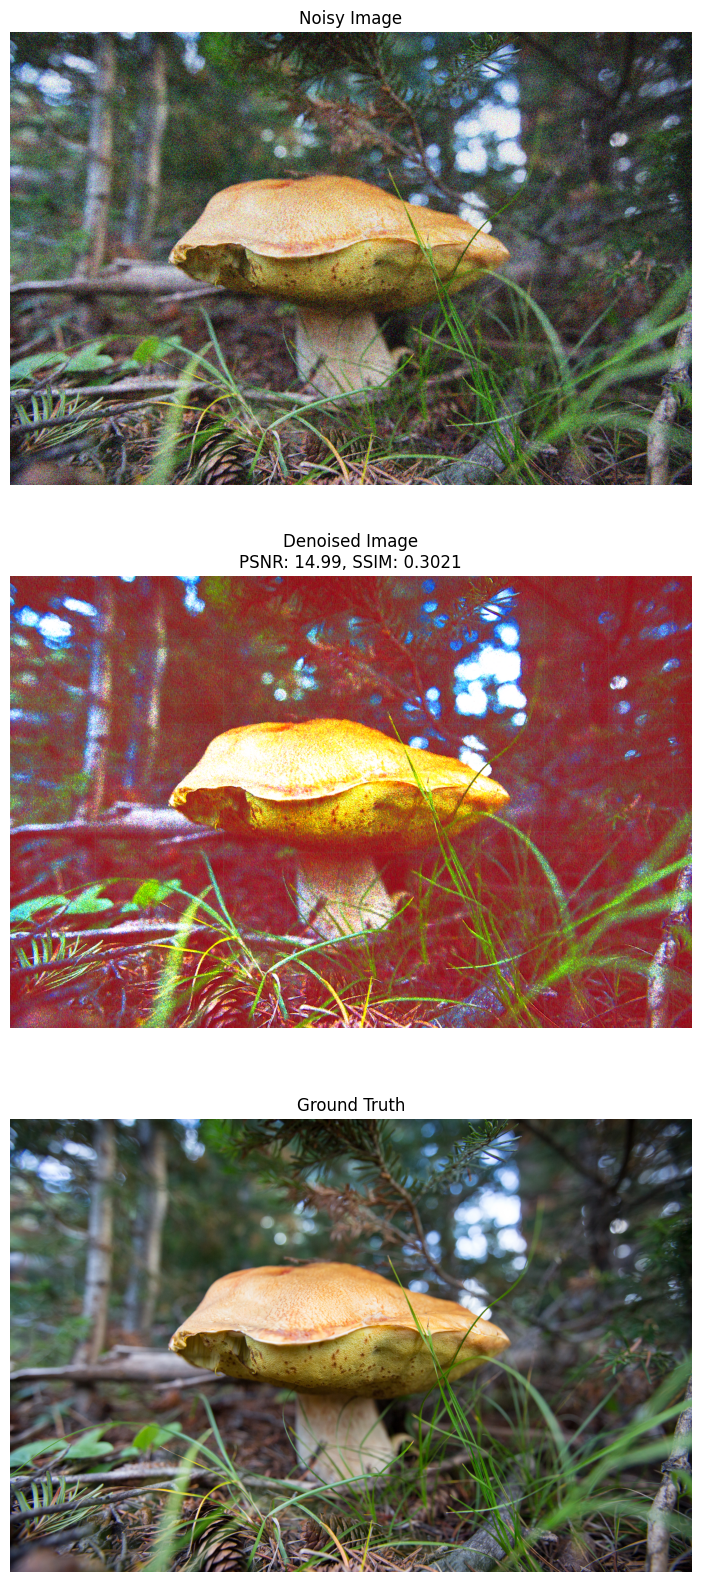

In [17]:
process_and_evaluate(model_path, clean_test_path, noisy_test_path)